In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import gym

%matplotlib inline

In [2]:
task = 'Ant-v1'
hidden_layer_num = 2
hidden_layer_size = 30

In [3]:
# TODO: this should be refactored and DRY from tuning-hyperparameters-and-visualization/train_humanoid.py

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


with open('../section-3-behavioral-cloning/train_test_data/ant_train_test.pkl', 'rb') as inf:
    X_tv, y_tv, X_test, y_test = pickle.load(inf)

tf.logging.info('{0}, {1}, {2}, {3}'.format(
    X_tv.shape, X_test.shape, y_tv.shape, y_test.shape
))

x_plh = tf.placeholder(tf.float32, shape=[None, X_tv.shape[1]])
y_plh = tf.placeholder(tf.float32, shape=[None, y_tv.shape[1]])

with tf.name_scope('fc1'):
    Wh_var = weight_variable([x_plh.shape.dims[1].value, hidden_layer_size])
    bh_var = bias_variable([hidden_layer_size])
    hh = tf.nn.sigmoid(tf.matmul(x_plh, Wh_var) + bh_var)

for i in range(hidden_layer_num - 1):
    with tf.name_scope('fc{0}'.format(i + 2)):
        Wh_var = weight_variable([hidden_layer_size, hidden_layer_size])
        bh_var = bias_variable([hidden_layer_size])
        hh = tf.nn.sigmoid(tf.matmul(hh, Wh_var) + bh_var)

with tf.name_scope('out'):
    W_var = weight_variable([hidden_layer_size, y_plh.shape.dims[1].value])
    b_var = bias_variable([y_plh.shape.dims[1].value])
    y_pred = tf.matmul(hh, W_var) + b_var

INFO:tensorflow:(16008, 111), (4002, 111), (16008, 8), (4002, 8)


In [4]:
with tf.name_scope('mse'):
    mse = tf.losses.mean_squared_error(labels=y_plh, predictions=y_pred)
    mse = tf.cast(mse, tf.float32)

with tf.name_scope('adam_optimizer'):
    train_op = tf.train.AdamOptimizer(1e-4).minimize(mse)

In [5]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [6]:
mse_tv, mse_test = [], []

bs = 128      # batch size
for k in range(10): # num. epochs
    print(k, end=',')
    for i in range(X_tv.shape[0] // bs):
        _x = X_tv[i * bs : (i+1) * bs, :]
        _y = y_tv[i * bs : (i+1) * bs, :]
        train_op.run(feed_dict={x_plh: _x, y_plh: _y})

    mse_tv.append(mse.eval(feed_dict={x_plh: X_tv, y_plh: y_tv}))
    mse_test.append(mse.eval(feed_dict={x_plh: X_test, y_plh: y_test}))

0,1,2,3,4,5,6,7,8,9,

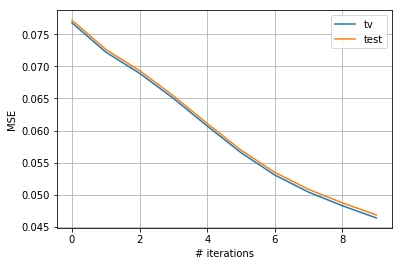

In [7]:
plt.plot(mse_tv, label='tv')
plt.plot(mse_test, label='test')
plt.legend()
plt.xlabel('# iterations')
plt.ylabel('MSE')
plt.grid()

In [8]:
print(mse_tv[-1], mse_test[-1])

0.046383 0.046843


# Visualize performance

In [9]:
def pred_action(obs):
    return y_pred.eval(feed_dict={x_plh: obs.reshape(1, -1)})

env = gym.make('Ant-v1')

obs = env.reset()
totalr = 0
done = False
max_timesteps = 600
for k in range(max_timesteps):
    if (k + 1) % 20 == 0:
        print(k + 1, end=',')
    action = pred_action(obs[None,:])
    obs, r, done, _ = env.step(action)
    totalr += r
    env.render()
env.render(close=True)
print()
print(totalr)
print(np.mean(totalr))

20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,
521.331088141
521.331088141


#### Expert performance

Expert's return at 600 timestep is around 2878.66413703.

Collected by running `python run_expert.py experts/Ant-v1.pkl Ant-v1 --max_timesteps 600 --num_rollouts 3 --render`